In [33]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

from matplotlib import cm
from tqdm import tqdm
import time
from tslearn import metrics
from tslearn.metrics import dtw, dtw_path
from scipy.spatial.distance import cdist
from numba import njit, prange
import numba

import stumpy  # local load

## Load dataset
https://archive.ics.uci.edu/ml/machine-learning-databases/00302/

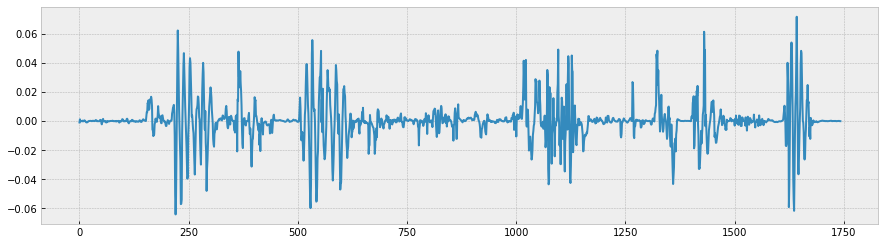

In [9]:
dfx = pd.read_csv("a1_va3.pkl")
v = dfx.values[:, 1]
plt.figure(figsize=(15, 4))
plt.plot(v)
plt.show()

## DTW MP
### 1.new code
DTW code will be imported from tsleran, so I'll skip explanation of this.

In [4]:
@njit(
    # "(f8[:], f8[:], i8)",
    fastmath=True,
)
def _njit_dtw(a, b, r):
    m = a.shape[0]
    l = 2*r+1
    cost = np.full(l, np.Inf)
    cost_prev = cost.copy()

    for i in range(m):
        k_ = max(-1, r-i-1)  # idx of updated cost 
        
        for j in range(max(0, i - r), min(m, i+r+1)):
            k_ += 1
            if ((i == 0) & (j == 0)):
                c = a[0] - b[0]
                cost[k_] = c*c
                continue

            # cell for update
            if (j-1 < 0) | (k_-1 < 0):
                y = np.inf
            else:
                y = cost[k_-1]

            if (i-1 < 0) | (k_ > 2*r-1):
                x = np.inf
            else:
                x = cost_prev[k_+1]

            if (i-1 < 0) | (j-1 < 0):
                z = np.inf
            else:
                z = cost_prev[k_]

            # update dtw
            c = a[i] - b[j]
            cost[k_] = min(x, y, z) + c*c

        cost_prev= cost.copy()

    return np.sqrt(cost[k_])

### 2.modified code
- Majority part from current stump(k-top)
- Replacing peason calculation and remove unnecessary for dtw.
- Peasron is "bigger is better", but dtw score is distance score. Therefore smaller is better.  
We have to swap inequality sign for it.
- Give additional parameter r: sakoe_chiba_radius. How large area would you search?

In [5]:
@njit
def _merge_topk_ρI_dtw(ρA, ρB, IA, IB):
    if ρA.ndim == 1:
        mask = (ρB < ρA) & (IB != IA)  # ------------ update
        ρA[mask] = ρB[mask]
        IA[mask] = IB[mask]
    else:
        k = ρA.shape[1]
        tmp_ρ = np.empty(k, dtype=np.float64)
        tmp_I = np.empty(k, dtype=np.int64)
        last_idx = k - 1
        for i in range(len(ρA)):
            overlap = set(IB[i]).intersection(set(IA[i]))
            aj, bj = last_idx, last_idx
            idx = last_idx
            # 2 * k iterations are required to traverse both A and B if needed.
            for _ in range(2 * k):
                if idx < 0:
                    break
                if bj >= 0 and ρB[i, bj] < ρA[i, aj]:  # ------------ update
                    if IB[i, bj] not in overlap:
                        tmp_ρ[idx] = ρB[i, bj]
                        tmp_I[idx] = IB[i, bj]
                        idx -= 1
                    bj -= 1
                else:
                    tmp_ρ[idx] = ρA[i, aj]
                    tmp_I[idx] = IA[i, aj]
                    idx -= 1
                    aj -= 1

            ρA[i] = tmp_ρ
            IA[i] = tmp_I

@njit(
    # "(f8[:], f8[:], i8, i8, f8[:], f8[:], f8[:], f8[:],"
    # "f8[:], f8[:], f8[:], f8[:], b1[:], b1[:], b1[:], b1[:],"
    # "i8[:], i8, i8, i8, f8[:, :, :], f8[:, :], f8[:, :]"
    # "i8[:, :, :], i8[:, :], i8[:, :], b1)",
    fastmath=True,
)
def _compute_diagonal_dtw(  # ------------ update (remove m-1 mean)
    T_A,
    T_B,
    m,
    r,
    M_T,
    μ_Q,
    Σ_T_inverse,
    σ_Q_inverse,
    T_A_subseq_isfinite,
    T_B_subseq_isfinite,
    T_A_subseq_isconstant,
    T_B_subseq_isconstant,
    diags,
    diags_start_idx,
    diags_stop_idx,
    thread_idx,
    ρ,
    ρL,
    ρR,
    I,
    IL,
    IR,
    ignore_trivial,
):

    n_A = T_A.shape[0]
    n_B = T_B.shape[0]
    uint64_m = np.uint64(m)
    
    for diag_idx in range(diags_start_idx, diags_stop_idx):
        g = diags[diag_idx]
        
        if g >= 0:
            iter_range = range(0, min(n_A - m + 1, n_B - m + 1 - g))
        else:
            iter_range = range(-g, min(n_A - m + 1, n_B - m + 1 - g))

        for i in iter_range:
            uint64_i = np.uint64(i)
            uint64_j = np.uint64(i + g)
            a = (T_A[uint64_i:uint64_i+uint64_m] - μ_Q[uint64_i])*σ_Q_inverse[uint64_i]
            b = (T_B[uint64_j:uint64_j+uint64_m] - M_T[uint64_j])*Σ_T_inverse[uint64_j]
            dist = _njit_dtw(a, b, r)# ------------ update
            
            if dist < ρ[thread_idx, uint64_i, 0]:  # ------------ update (swap)
                idx = np.searchsorted(ρ[thread_idx, uint64_i], dist)# ------------ update
                stumpy.core._shift_insert_at_index(
                    ρ[thread_idx, uint64_i], idx, dist, shift="right"  # ------------ update (left >> right)
                )
                stumpy.core._shift_insert_at_index(
                    I[thread_idx, uint64_i], idx, uint64_j, shift="right"  # ------------ update (left >> right)
                )

            if ignore_trivial:  # self-joins only
                if dist < ρ[thread_idx, uint64_j, 0]:  # ------------ update (swap)
                    idx = np.searchsorted(ρ[thread_idx, uint64_j], dist)# ------------ update
                    stumpy.core._shift_insert_at_index(
                        ρ[thread_idx, uint64_j], idx, dist, shift="right"  # ------------ update (left >> right)
                    )
                    stumpy.core._shift_insert_at_index(
                        I[thread_idx, uint64_j], idx, uint64_i, shift="right"  # ------------ update (left >> right)
                    )

                if uint64_i < uint64_j:
                    # left pearson correlation and left matrix profile index
                    if dist < ρL[thread_idx, uint64_j]:  # ------------ update (swap)
                        ρL[thread_idx, uint64_j] = dist
                        IL[thread_idx, uint64_j] = uint64_i

                    # right pearson correlation and right matrix profile index
                    if dist < ρR[thread_idx, uint64_i]:  # ------------ update (swap)
                        ρR[thread_idx, uint64_i] = dist
                        IR[thread_idx, uint64_i] = uint64_j
    return
    

@njit(
    # "(f8[:], f8[:], i8, i8, f8[:], f8[:], f8[:], f8[:],"
    # "b1[:], b1[:], b1[:], b1[:], i8[:], b1, i8)",
    parallel=True,
    fastmath=True,
)
def _dtwMP(
    T_A,
    T_B,
    m,
    r,
    M_T,
    μ_Q,
    Σ_T_inverse,
    σ_Q_inverse,
    T_A_subseq_isfinite,
    T_B_subseq_isfinite,
    T_A_subseq_isconstant,
    T_B_subseq_isconstant,
    diags,
    ignore_trivial,
    k,
):

    n_A = T_A.shape[0]
    n_B = T_B.shape[0]
    l = n_A - m + 1
    n_threads = numba.config.NUMBA_NUM_THREADS

    ρ = np.full((n_threads, l, k), np.Inf, dtype=np.float64)  # ------------ update (smaller is better)
    I = np.full((n_threads, l, k), -1, dtype=np.int64)
    ρL = np.full((n_threads, l), np.Inf, dtype=np.float64)  # ------------ update (smaller is better)
    IL = np.full((n_threads, l), -1, dtype=np.int64)
    ρR = np.full((n_threads, l), np.Inf, dtype=np.float64)  # ------------ update (smaller is better)
    IR = np.full((n_threads, l), -1, dtype=np.int64)

    ndist_counts = stumpy.core._count_diagonal_ndist(diags, m, n_A, n_B)
    diags_ranges = stumpy.core._get_array_ranges(ndist_counts, n_threads, False)
    
    for thread_idx in prange(n_threads):
        _compute_diagonal_dtw(
            T_A,
            T_B,
            m,
            r,
            M_T,
            μ_Q,
            Σ_T_inverse,
            σ_Q_inverse,
            T_A_subseq_isfinite,
            T_B_subseq_isfinite,
            T_A_subseq_isconstant,
            T_B_subseq_isconstant,
            diags,
            diags_ranges[thread_idx, 0],
            diags_ranges[thread_idx, 1],
            thread_idx,
            ρ,
            ρL,
            ρR,
            I,
            IL,
            IR,
            ignore_trivial,
        )
    
    for thread_idx in range(1, n_threads):
        # update top-k arrays
        _merge_topk_ρI_dtw(ρ[0], ρ[thread_idx], I[0], I[thread_idx])  # ------------ update

        # update left matrix profile and matrix profile indices
        mask = ρL[0] > ρL[thread_idx]  # ------------ update (swap)
        ρL[0][mask] = ρL[thread_idx][mask]
        IL[0][mask] = IL[thread_idx][mask]

        # update right matrix profile and matrix profile indices
        mask = ρR[0] > ρR[thread_idx]  # ------------ update (swap)
        ρR[0][mask] = ρR[thread_idx][mask]
        IR[0][mask] = IR[thread_idx][mask]
                    
    
    dist = ρ[0, :, ::-1]
    I = I[0, :, ::-1]
    dist_L = ρL[0, :]
    dist_R = ρR[0, :]

    return dist, dist_L, dist_R, I, IL[0], IR[0]
    
def dtwMP(T_A, m, r, T_B=None, ignore_trivial=True, k=1):
    if T_B is None:
        T_B = T_A
        ignore_trivial = True

    (
        T_A,
        μ_Q,
        σ_Q_inverse,
        _,  # ------------ update
        T_A_subseq_isfinite,
        T_A_subseq_isconstant,
    ) = stumpy.core.preprocess_diagonal(T_A, m)

    (
        T_B,
        M_T,
        Σ_T_inverse,
        _,  # ------------ update
        T_B_subseq_isfinite,
        T_B_subseq_isconstant,
    ) = stumpy.core.preprocess_diagonal(T_B, m)

    n_A = T_A.shape[0]
    n_B = T_B.shape[0]
    l = n_A - m + 1
    n_threads = numba.config.NUMBA_NUM_THREADS

    excl_zone = int(np.ceil(m/ stumpy.config.STUMPY_EXCL_ZONE_DENOM))

    if ignore_trivial:
        diags = np.arange(excl_zone + 1, n_A - m + 1, dtype=np.int64)
    else:
        diags = np.arange(-(n_A - m + 1) + 1, n_B - m + 1, dtype=np.int64)


    P, PL, PR, I, IL, IR = _dtwMP(
        T_A,
        T_B,
        m,
        r,
        M_T,
        μ_Q,
        Σ_T_inverse,
        σ_Q_inverse,
        T_A_subseq_isfinite,
        T_B_subseq_isfinite,
        T_A_subseq_isconstant,
        T_B_subseq_isconstant,
        diags,
        ignore_trivial,
        k
    )
    
    out = np.empty((l, 2 * k + 2), dtype=object)  # last two columns are to
    # store left and right matrix profile indices
    out[:, :k] = P
    out[:, k:] = np.column_stack((I, IL, IR))

    return out

In [10]:
v = v.astype(np.float64)
m = 160
r = 8  #sakoe_chiba_radius or maxwarp(paper)
out_dtw = dtwMP(v, m, r)

### 3.comparison with stump
Similar results were obtained, (Paper doesn't have exact number.)

In [11]:
out_stump = stumpy.stump(v, m)

Paper example, calculation of comparison

<img src="human_g.png" width="800">

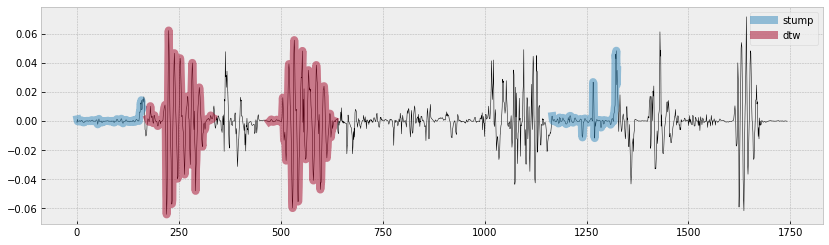

In [17]:
idx_a_dtw = np.argmin(out_dtw[:,0])
idx_b_dtw = out_dtw[:,1][idx_a_dtw]
idx_a_stump = np.argmin(out_stump[:,0])
idx_b_stump = out_stump[:,1][idx_a_stump]

x_ = np.arange(len(v))
plt.plot(v, color="k", linewidth=0.5)
plt.plot(x_[idx_a_stump:idx_a_stump+m],v[idx_a_stump:idx_a_stump+m], color="C0", alpha=0.5, linewidth=8, label="stump")
plt.plot(x_[idx_b_stump:idx_b_stump+m],v[idx_b_stump:idx_b_stump+m], color="C0", alpha=0.5, linewidth=8)
plt.plot(x_[idx_a_dtw:idx_a_dtw+m],v[idx_a_dtw:idx_a_dtw+m], color="C1", alpha=0.5, linewidth=8, label="dtw")
plt.plot(x_[idx_b_dtw:idx_b_dtw+m],v[idx_b_dtw:idx_b_dtw+m], color="C1", alpha=0.5, linewidth=8)
plt.legend()
plt.show()

### 4.Matrix profile and DTW MP

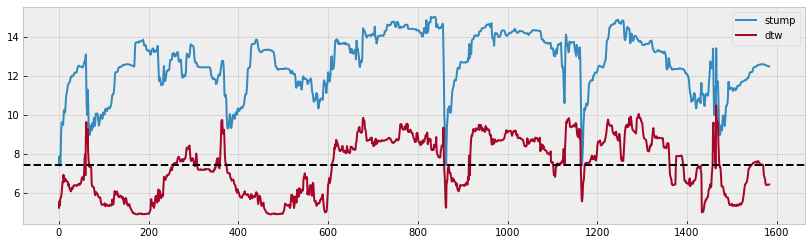

In [22]:
best_so_far = np.min(out_stump[:,0])  # swamp algo paramter

plt.plot(out_stump[:,0], label="stump")
plt.plot(out_dtw[:,0], label="dtw")
plt.axhline(best_so_far, color="k", linestyle="--")
plt.legend()
plt.show()

## DTW comparison with tslearn

In [25]:
v_a, v_b = v[:m], v[200:200+m]
r = 20
v_a = v_a.astype(np.float64)
v_b = v_b.astype(np.float64)
dtw_ = _njit_dtw(v_a, v_b, r)
dtw_tslearn = dtw(v_a, v_b, global_constraint="sakoe_chiba", sakoe_chiba_radius=r)
print(dtw_, ":DTW")
print(dtw_tslearn, ":DTW tslearn")

0.24971504880952589 :DTW
0.2497150488095259 :DTW tslearn


## DTW Masks List

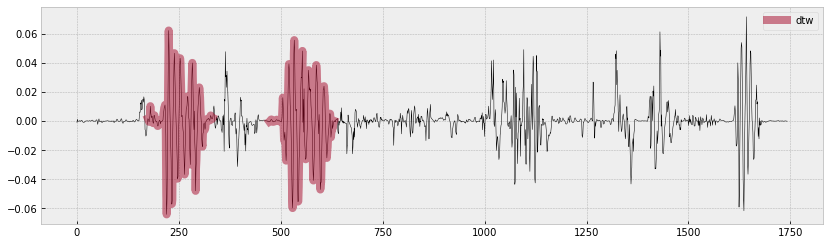

In [30]:
x_ = np.arange(len(v))
plt.plot(v, color="k", linewidth=0.5)
plt.plot(x_[idx_a_dtw:idx_a_dtw+m],v[idx_a_dtw:idx_a_dtw+m], color="C1", alpha=0.5, linewidth=8, label="dtw")
plt.plot(x_[idx_b_dtw:idx_b_dtw+m],v[idx_b_dtw:idx_b_dtw+m], color="C1", alpha=0.5, linewidth=8)
plt.legend()
plt.show()

### Itakura

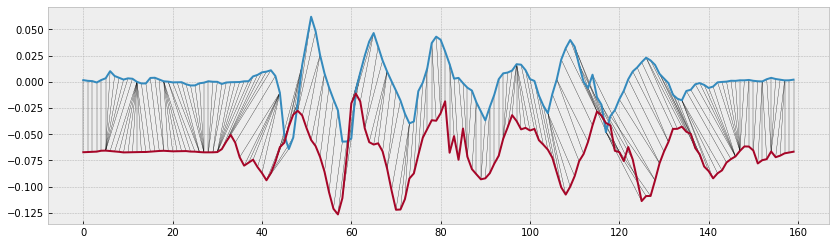

In [31]:
v_a, v_b = v[idx_a_dtw:idx_a_dtw+m], v[idx_b_dtw:idx_b_dtw+m]

path, sim = metrics.dtw_path(v_a, v_b, global_constraint="itakura", itakura_max_slope=2) # default setting(intendedly specified)
gap_plot = np.max(v_b)*1.2
x_path = np.asarray(path)
y_path = np.stack([v_a[x_path[:, 0]], v_b[x_path[:, 1]]-gap_plot]).T
for i in range(x_path.shape[0]):
    plt. plot(x_path[i, :], y_path[i, :], linewidth=0.3, color="k")
plt.plot(v_a)
plt.plot(v_b-gap_plot)
plt.show()

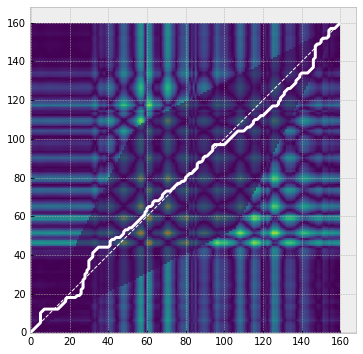

In [34]:
mat = cdist(v_a.reshape(-1, 1), v_b.reshape(-1, 1))
max_slope = 2
sz1 = len(v_a)
sz2 = len(v_b)
mask = metrics.itakura_mask(sz1, sz2, max_slope)

plt.figure(figsize=(6, 6))
plt.imshow(mat, origin='lower')
plt.imshow(mask, origin='lower', alpha=0.5)
plt.plot([j for (i, j) in path], [i for (i, j) in path], color="w" ,linewidth=3)
plt.plot([0, len(v_a)], [0, len(v_b)], color="w" ,linewidth=1, linestyle="--")
plt.show()

Greyscaled area is searched.  
White line is dtw calculation matching path.

### Sakoe-chiba

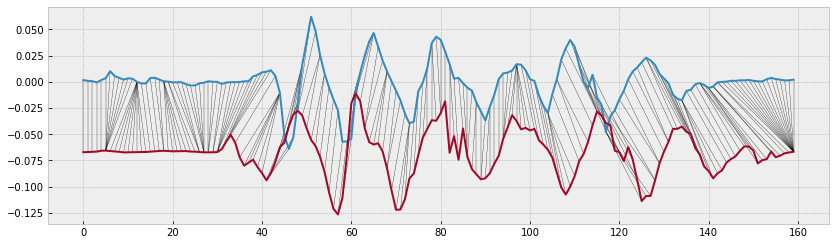

In [35]:
v_a, v_b = v[idx_a_dtw:idx_a_dtw+m], v[idx_b_dtw:idx_b_dtw+m]

path, sim = metrics.dtw_path(v_a, v_b, global_constraint="sakoe_chiba", sakoe_chiba_radius=r) # default setting(intendedly specified)
gap_plot = np.max(v_b)*1.2
x_path = np.asarray(path)
y_path = np.stack([v_a[x_path[:, 0]], v_b[x_path[:, 1]]-gap_plot]).T
for i in range(x_path.shape[0]):
    plt. plot(x_path[i, :], y_path[i, :], linewidth=0.3, color="k")
plt.plot(v_a)
plt.plot(v_b-gap_plot)
plt.show()

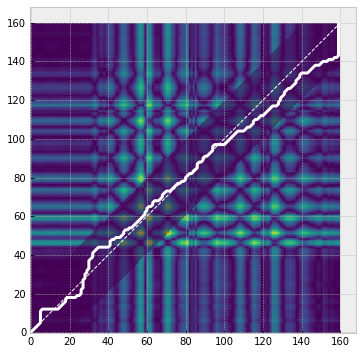

In [36]:
mat = cdist(v_a.reshape(-1, 1), v_b.reshape(-1, 1))
max_slope = 2
sz1 = len(v_a)
sz2 = len(v_b)
mask = metrics.sakoe_chiba_mask(sz1, sz2, r)

plt.figure(figsize=(6, 6))
plt.imshow(mat, origin='lower')
plt.imshow(mask, origin='lower', alpha=0.5)
plt.plot([j for (i, j) in path], [i for (i, j) in path], color="w" ,linewidth=3)
plt.plot([0, len(v_a)], [0, len(v_b)], color="w" ,linewidth=1, linestyle="--")
plt.show()

Greyscaled area is searched.  
White line is dtw calculation matching path.